In [367]:
#Question 1 
#In this question, we are going to create a sankey diagram with multiple levels. 
#We will combine the multilevel dataset with the kirby21 dataset (subjectData) to plot the diagram
#The data and code sources come from class lectures with the Bloomberg School of Public Health at JHU
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.offline import plot 
from IPython import display

In [356]:
# Read in the data
url = "https://raw.githubusercontent.com/bcaffo/MRIcloudT1volumetrics/master/inst/extdata/multilevel_lookup_table.txt"
dat = pd.read_csv(url, sep="\t").drop(['Level5'], axis=1)
dat = dat.rename(columns={
    "modify": "roi",
    "modify.1": "level4",
    "modify.2": "level3",
    "modify.3": "level2",
    "modify.4": "level1"})
dat = dat[['roi', 'level4', 'level3', 'level2', 'level1']]
dat['level2'] = dat['level2'].str.strip()

# Select the id variable as 127
id = 127

# Read in the subject data
subjectData = pd.read_csv("https://raw.githubusercontent.com/smart-stats/ds4bio_book/main/book/assetts/kirby21AllLevels.csv").drop(['Unnamed: 0'], axis = 1)

# Make lists for roi 
roi = subjectData.loc[(subjectData.id == id) & (subjectData.type == 1), 'roi'].tolist()
roi = ['ICV'] + roi

# Extract data with type 1 and level 5 and id. Extract columns of roi and volume
subjectData = subjectData.loc[(subjectData.type == 1) & (subjectData.level == 5) & (subjectData.id == id), ['roi', 'volume']]

# Combine two datasets by roi and assign new values 
subjectData = pd.merge(subjectData, dat, on="roi")
subjectData['licv'] = "ICV"
subjectData['comp'] = subjectData['volume'] / np.sum(subjectData['volume'])

# Data preparation for the diagram
# from icv level to Level 1
lv1 = subjectData.groupby(['licv', 'level1']).sum().reset_index()
lv1 = lv1.rename(columns={'level1': 'target', 'licv': 'source'}).drop(['volume'], axis=1)

# from Level 1 to Level 2
lv2 = subjectData.groupby(['level1', 'level2']).sum().reset_index()
lv2 = lv2.rename(columns={'level2': 'target', 'level1': 'source'}).drop(['volume'], axis=1)

# link the datasets created from last step
dig_pan = pd.concat([lv1, lv2])

# Replace the names with a list of integers 
dig_pan['target_ind'] = [roi.index(x) for x in dig_pan['target']]
dig_pan['source_ind'] = [roi.index(x) for x in dig_pan['source']]

dig_pan

/var/folders/pl/kgrsfjf50jd0lbps2dk3v47h0000gn/T/ipykernel_96994/3413702257.py:33: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/var/folders/pl/kgrsfjf50jd0lbps2dk3v47h0000gn/T/ipykernel_96994/3413702257.py:37: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,source,target,comp,target_ind,source_ind
0,ICV,CSF,0.079417,8,0
1,ICV,Diencephalon_L,0.008548,3,0
2,ICV,Diencephalon_R,0.008362,4,0
3,ICV,Mesencephalon,0.007430,5,0
4,ICV,Metencephalon,0.115313,6,0
5,ICV,Myelencephalon,0.003599,7,0
6,ICV,Telencephalon_L,0.384220,1,0
7,ICV,Telencephalon_R,0.393111,2,0
0,CSF,Sulcus_L,0.024577,26,8
1,CSF,Sulcus_R,0.021714,27,8


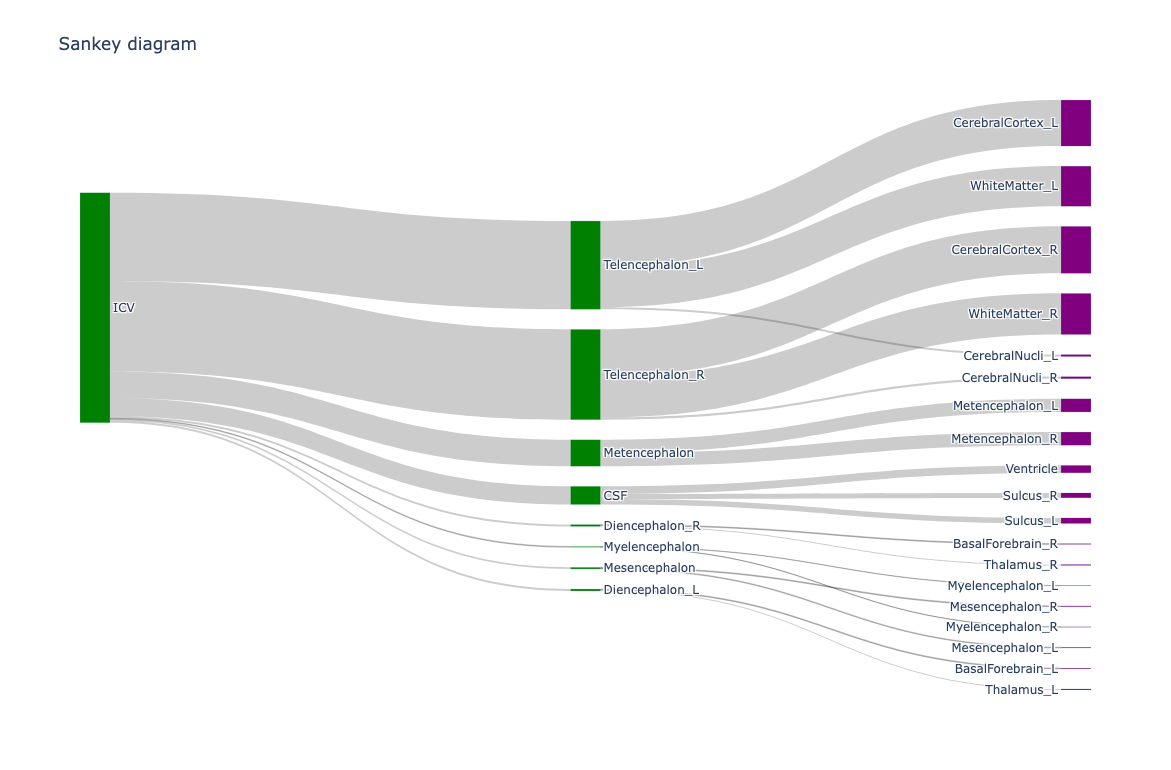

In [374]:
def genSankey(dig_pan,dcols=[],vcols='',title='Sankey Plot in Python'):
    label = []
    color = ["green","purple"]
    cols = []
    for i in dcols:
        label0 =  list(set(dig_pan[i].values))
        cols.append(len(label0))
        label = label + label0
        
    #Define the unique label variable   
    label = list(dict.fromkeys(label))

    #Define the color variable
    colorsnum = []
    for ind, coln in enumerate(cols):
        colorsnum = colorsnum + [color[ind]]*coln
        
    #Define the pairs of source & target
    for a in range(len(dcols)-1):
        if a==0:
            sourcetar = dig_pan[[dcols[a],dcols[a+1],vcols]]
            sourcetar.columns = ['source','target','value_num']
        else:
            tdat = dig_pan[[dcols[a],dcols[a+1],vcols]]
            tdat.columns = ['source','target','value_num']
            sourcetar = pd.concat([sourcetar,tdat])
        sourcetar = sourcetar.groupby(['source','target']).agg({'value_num':'sum'}).reset_index()
        
    #Define index for the source and target
    sourcetar['sourceind'] = sourcetar['source'].apply(lambda x: label.index(x))
    sourcetar['targetind'] = sourcetar['target'].apply(lambda x: label.index(x))
    
    # creating the sankey diagram
    figdf = dict(type='sankey', node = dict(pad = 20, thickness = 30,line = dict(width = 0.2,color = "lightblue"),
                                            label = label, color = colorsnum),link = dict(
        source = sourcetar['sourceind'],
        target = sourcetar['targetind'],
        value = sourcetar['value_num']))
    layout =  dict(title = "Sankey diagram",font = dict(size = 12))
    fig = dict(data=[figdf], layout=layout)
    return fig

#Display the figure 
fdat = genSankey(dig_pan, dcols=['source','target'],vcols='comp')
fig = go.Figure(fdat)
fig.show()
#save this file as a standalong html file:
fig.write_html("Sankey_diagram.html")
display.Image("sankey.png")

#Question 2: Create a simple webpage containing this graphic and host it on github pages. Since the file is too large, we could not show the interactive graph in python. Instead, I uploaded the file into the repository

https://github.com/hliu154/dshw2.io/blob/main/Sankey_diagram.html
png form: https://github.com/hliu154/dshw2.io/blob/main/sankey.png

#Question 3: Create the opioid sqlite database from https://smart-stats.github.io/ds4bio_book/book/_build/html/sqlite.html. However, only go to the step where the csv files are read into the database. Then exit sqlite and you should have a file opioid.db that has the data. Next, read the three tables into pandas dataframes and do the data wrangling from the sqlite chapter directly in pandas. Add the python code to your hw4.ipynb file.

In [311]:
import pandas as pd
import numpy as np
import sqlite3 as sq3
import plotly.express as px
import plotly.graph_objects as go

In [312]:
# creating file path
dbfile = '/Users/masonliu/Desktop/opioid.db'
# Create a SQL connection to our SQLite database
con = sq3.connect(dbfile)
#Check on 3 variables in the table
population = pd.read_sql_query("SELECT * from population", con)
annual = pd.read_sql_query("SELECT * from annual", con)
land = pd.read_sql_query("SELECT * from land", con)
print(population.shape[0]) #Population has 56531 rows of data
print(annual.shape[0]) #Annual has 55517 rows of data
print(land.shape[0]) #Land has 6397 rows of data

56531
55517
6397


In [313]:
population 

,,BUYER_COUNTY,BUYER_STATE,countyfips,STATE,COUNTY,county_name,NAME,variable,year,population
0,1,AUTAUGA,AL,01001,1,1,Autauga,"Autauga County, Alabama",B01003_001,2006,51328
1,2,BALDWIN,AL,01003,1,3,Baldwin,"Baldwin County, Alabama",B01003_001,2006,168121
2,3,BARBOUR,AL,01005,1,5,Barbour,"Barbour County, Alabama",B01003_001,2006,27861
3,4,BIBB,AL,01007,1,7,Bibb,"Bibb County, Alabama",B01003_001,2006,22099
4,5,BLOUNT,AL,01009,1,9,Blount,"Blount County, Alabama",B01003_001,2006,55485
...,...,...,...,...,...,...,...,...,...,...,...
56526,28261,WASHAKIE,WY,56043,56,43,Washakie,"Washakie County, Wyoming",B01003_001,2014,8444
56527,28262,WESTON,WY,56045,56,45,Weston,"Weston County, Wyoming",B01003_001,2014,7135
56528,28263,SKAGWAY,AK,02230,2,230,Skagway,"Skagway Municipality, Alaska",B01003_001,2014,996
56529,28264,HOONAH ANGOON,AK,02105,2,105,Hoonah Angoon,"Hoonah-Angoon Census Area, Alaska",B01003_001,2014,2126


In [314]:
land

,,Areaname,STCOU,LND010190F,LND010190D,LND010190N1,LND010190N2,LND010200F,LND010200D,LND010200N1,...,LND110210N1,LND110210N2,LND210190F,LND210190D,LND210190N1,LND210190N2,LND210200F,LND210200D,LND210200N1,LND210200N2
0,1,UNITED STATES,00000,0,3787425.08,0000,0000,0,3794083.06,0000,...,0000,0000,0,251083.35,0000,0000,0,256644.62,0000,0000
1,2,ALABAMA,01000,0,52422.94,0000,0000,0,52419.02,0000,...,0000,0000,0,1672.71,0000,0000,0,1675.01,0000,0000
2,3,"Autauga, AL",01001,0,604.49,0000,0000,0,604.45,0000,...,0000,0000,0,8.48,0000,0000,0,8.48,0000,0000
3,4,"Baldwin, AL",01003,0,2027.08,0000,0000,0,2026.93,0000,...,0000,0000,0,430.55,0000,0000,0,430.58,0000,0000
4,5,"Barbour, AL",01005,0,904.59,0000,0000,0,904.52,0000,...,0000,0000,0,19.59,0000,0000,0,19.61,0000,0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6392,3194,"Sweetwater, WY",56037,0,10491.73,0000,0000,0,10491.17,0000,...,0000,0000,0,65.86,0000,0000,0,65.87,0000,0000
6393,3195,"Teton, WY",56039,0,4221.96,0000,0000,0,4221.8,0000,...,0000,0000,0,214.02,0000,0000,0,214.04,0000,0000
6394,3196,"Uinta, WY",56041,0,2087.66,0000,0000,0,2087.56,0000,...,0000,0000,0,5.91,0000,0000,0,5.9,0000,0000
6395,3197,"Washakie, WY",56043,0,2242.85,0000,0000,0,2242.75,0000,...,0000,0000,0,2.69,0000,0000,0,2.69,0000,0000


In [315]:
annual #We see that Annual has some NA values for Buyer_vounty and countyfips, so I will remove these Na in the next step

,,BUYER_COUNTY,BUYER_STATE,year,count,DOSAGE_UNIT,countyfips
0,1,ABBEVILLE,SC,2006,877,363620,45001
1,2,ABBEVILLE,SC,2007,908,402940,45001
2,3,ABBEVILLE,SC,2008,871,424590,45001
3,4,ABBEVILLE,SC,2009,930,467230,45001
4,5,ABBEVILLE,SC,2010,1197,539280,45001
...,...,...,...,...,...,...,...
55512,27754,NA,NV,2007,447,200600,NA
55513,27755,NA,NV,2008,5,2200,NA
55514,27756,NA,OH,2006,23,5100,NA
55515,27757,NA,PR,2006,10,17800,NA


In [318]:
#Removing NAs in buyer_county variable 
annual.drop(annual[annual.BUYER_COUNTY == 'NA'].index, inplace =True)
annual #Now we can see that the number of row of annual decreased from 55517 to 55483

,,BUYER_COUNTY,BUYER_STATE,year,count,DOSAGE_UNIT,countyfips
0,1,ABBEVILLE,SC,2006,877,363620,45001
1,2,ABBEVILLE,SC,2007,908,402940,45001
2,3,ABBEVILLE,SC,2008,871,424590,45001
3,4,ABBEVILLE,SC,2009,930,467230,45001
4,5,ABBEVILLE,SC,2010,1197,539280,45001
...,...,...,...,...,...,...,...
55495,27737,ZAVALA,TX,2010,248,200100,48507
55496,27738,ZAVALA,TX,2011,406,244800,48507
55497,27739,ZAVALA,TX,2012,473,263700,48507
55498,27740,ZAVALA,TX,2013,399,186700,48507


In [319]:
#Selecting variables of  Areaname, STCOU, LND010190D from land;
Land_for_merge=land[['Areaname', 'STCOU', 'LND010190D']]
#Changing the column name from STCOU to countyfips;
Land_for_merge=Land_for_merge.rename(columns={'STCOU':'countyfips'})
Land_for_merge.head()

,Areaname,countyfips,LND010190D
0,UNITED STATES,00000,3787425.08
1,ALABAMA,01000,52422.94
2,"Autauga, AL",01001,604.49
3,"Baldwin, AL",01003,2027.08
4,"Barbour, AL",01005,904.59


In [320]:
#Merging the data from annual and land based on the common column of countyfips
annual_land = pd.merge(annual, Land_for_merge, on = 'countyfips', how='left')
annual_land

,,BUYER_COUNTY,BUYER_STATE,year,count,DOSAGE_UNIT,countyfips,Areaname,LND010190D
0,1,ABBEVILLE,SC,2006,877,363620,45001,"Abbeville, SC",511.1
1,1,ABBEVILLE,SC,2006,877,363620,45001,"Abbeville, SC",511.1
2,2,ABBEVILLE,SC,2007,908,402940,45001,"Abbeville, SC",511.1
3,2,ABBEVILLE,SC,2007,908,402940,45001,"Abbeville, SC",511.1
4,3,ABBEVILLE,SC,2008,871,424590,45001,"Abbeville, SC",511.1
...,...,...,...,...,...,...,...,...,...
109438,27739,ZAVALA,TX,2012,473,263700,48507,"Zavala, TX",1301.82
109439,27740,ZAVALA,TX,2013,399,186700,48507,"Zavala, TX",1301.82
109440,27740,ZAVALA,TX,2013,399,186700,48507,"Zavala, TX",1301.82
109441,27741,ZAVALA,TX,2014,162,148930,48507,"Zavala, TX",1301.82


#Question 4: Create an interactive scatter plot of average number of opiod pills by year plot using plotly. See the example here. Don't do the intervals (little vertical lines), only the points. Add your plot to an html file with your repo for your Sanky diagram and host it publicly. Put a link to your hosted file in a markdown cell of your hw4.ipynb file. Note, an easy way to create a webpage with this graphic is to export an ipynb as an html file.

In [332]:
annual_plot = annual[['year', 'DOSAGE_UNIT']]
annual_plot

,year,DOSAGE_UNIT
0,2006,363620
1,2007,402940
2,2008,424590
3,2009,467230
4,2010,539280
...,...,...
55495,2010,200100
55496,2011,244800
55497,2012,263700
55498,2013,186700


In [338]:
#First convert the data type into int, and then convert unit into pills per millions
annual_plot['DOSAGE_UNIT_NEW'] = annual_plot['DOSAGE_UNIT'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)
annual_plot['Pills_per_millions'] = (annual_plot['DOSAGE_UNIT_NEW'].astype(float) / 1000000).round(4)
annual_plot.head()

/var/folders/pl/kgrsfjf50jd0lbps2dk3v47h0000gn/T/ipykernel_96994/2257459639.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,year,DOSAGE_UNIT,DOSAGE_UNIT_NEW,Pills_per_millions
0,2006,363620,363620.0,0.3636
1,2007,402940,402940.0,0.4029
2,2008,424590,424590.0,0.4246
3,2009,467230,467230.0,0.4672
4,2010,539280,539280.0,0.5393


In [339]:
#Change the data into two columns, where pills are grouped by years
plotdf = annual_plot[['Pills_per_millions', 'year']].groupby('year', as_index=False).mean()
plotdf.head()

,year,Pills_per_millions
0,2006,111.330256
1,2007,5.165994
2,2008,6.502431
3,2009,205.550035
4,2010,37.976661


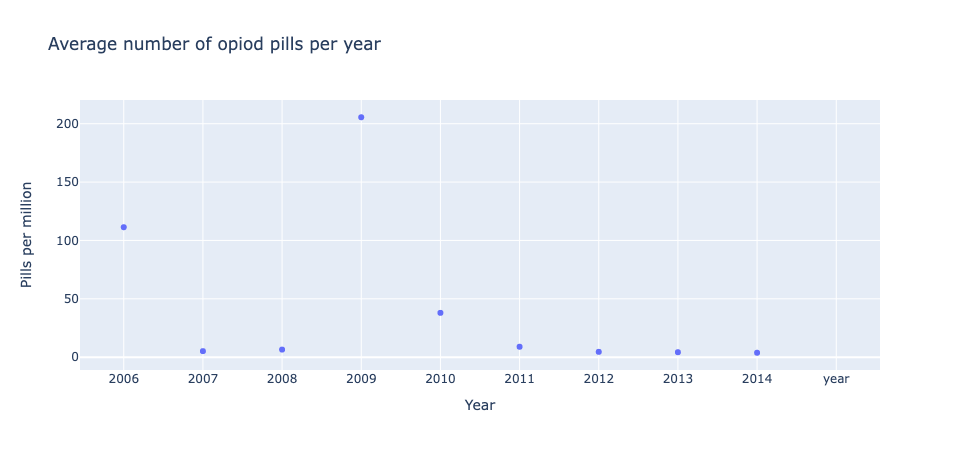

In [373]:
fig1 = px.scatter(x = plotdf.year, y = plotdf.Pills_per_millions, title = 'Average number of opiod pills per year', labels = {'x': 'Year', 'y': 'Pills per million'})
fig1.show()
fig1.write_html("Q4.html")
display.Image("scatter.png")

In [ ]:
#The file is too large to be published. However, the link to the html file is attached, along with a link to a png output
https://github.com/hliu154/dshw2.io/blob/main/Q4.html
https://github.com/hliu154/dshw2.io/blob/main/scatter.png